In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

class CondGenerator(torch.nn.Module):
    def __init__(self, num_class, embedding_dim, latent_dim):
        super().__init__()
        self.label_embeddings = nn.Sequential(
            nn.Embedding(num_class, embedding_dim),
            nn.Linear(embedding_dim, 1 * 7 * 7),
        )
        self.latent_noise = nn.Sequential(
            nn.Linear(latent_dim, 255 * 7 * 7),
            nn.ReLU(),
        )
        self.G = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z, y):
        """The forward function should return batch of images."""
        z = self.latent_noise(z).reshape(-1, 255, 7, 7)
        y = self.label_embeddings(y).reshape(-1, 1, 7, 7)
        x = torch.cat((z, y), dim=1)
        x = self.G(x)
        return x


class CondDiscriminator(torch.nn.Module):
    def __init__(self, num_class, embedding_dim, channel_dim):
        super().__init__()
        self.label_embeddings = nn.Sequential(
            nn.Embedding(num_class, embedding_dim),
            nn.Linear(embedding_dim, channel_dim * 28 * 28),
            nn.ReLU()
        )
        self.D = nn.Sequential(
            # half of the channels comes from the image, and the other half is from the label
            nn.Conv2d(2 * channel_dim, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(),
        )
        self.channel_dim = channel_dim

    def forward(self, x, y):
        """The forward function should return the scores."""
        y = self.label_embeddings(y).reshape(-1, self.channel_dim, 28, 28)
        x = torch.concat((x, y), dim=1)
        p = self.D(x)
        return p


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.001)
    return


class CDCGAN(object):
    def __init__(self, num_class, embedding_dim, channel_dim, latent_dim, epochs, lr, device):
        self.G = CondGenerator(num_class, embedding_dim, latent_dim).apply(weights_init).to(device)
        self.D = CondDiscriminator(num_class, embedding_dim, channel_dim).apply(weights_init).to(device)
        self.loss = nn.BCELoss()

        self.d_optimizer = torch.optim.Adam(
            self.D.parameters(), lr=lr, betas=(0.5, 0.999)
        )
        self.g_optimizer = torch.optim.Adam(
            self.G.parameters(), lr=lr, betas=(0.5, 0.999)
        )

        self.num_class = num_class
        self.embedding_dim = embedding_dim
        self.channel_dim = channel_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr
        self.device = device

    def train(self, train_loader, verbose_period=2):
        for epoch in range(self.epochs):
            total_d_loss = 0
            total_g_loss = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for images, y in bar:
                    batch_size = images.size(0)
                    # Step 1: Train discriminator
                    z = torch.rand((batch_size, self.latent_dim)).to(self.device)

                    real_labels = torch.ones(batch_size)
                    fake_labels = torch.zeros(batch_size)

                    images, y = images.to(self.device), y.to(self.device).long()

                    real_labels, fake_labels = real_labels.to(self.device), fake_labels.to(self.device)

                    # Compute the BCE Loss using real images
                    real_scores = self.D(images, y)
                    real_scores = torch.squeeze(real_scores)
                    d_loss_real = self.loss(real_scores, real_labels)

                    # Compute the BCE Loss using fake images
                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    d_loss_fake = self.loss(fake_scores, fake_labels)

                    # Optimize discriminator
                    d_loss = d_loss_real + d_loss_fake
                    self.D.zero_grad()
                    d_loss.backward()
                    # max log(D(x)) + log(1 - D(G(z))) <=> min -[ log(D(x)) + log(1 - D(G(z))) ]
                    self.d_optimizer.step()

                    # Step 2: Train Generator
                    z = torch.randn(batch_size, self.latent_dim).to(self.device)

                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    g_loss = self.loss(fake_scores, real_labels)

                    self.D.zero_grad()
                    self.G.zero_grad()
                    g_loss.backward()
                    # min log(1 - D(G(z))) => min -[ log(D(G(z))) ]
                    self.g_optimizer.step()

                    # update bar
                    num_batches += 1
                    total_d_loss += d_loss.item()
                    total_g_loss += g_loss.item()
                    bar.set_postfix(
                        d_loss=float(total_d_loss / num_batches),
                        g_loss=float(total_g_loss / num_batches),
                    )
            if total_d_loss / num_batches < 1e-3 or total_g_loss / num_batches > 10:
                print(
                    f"Discriminator loss is too small and generator loss is too high at epoch:{epoch}, which indicate a potential saturation problem."
                )
                print("Now, re-initialize and re-train...")
                self.__init__(
                    self.num_class,
                    self.embedding_dim,
                    self.channel_dim,
                    self.latent_dim,
                    self.epochs,
                    self.lr,
                    self.device
                )
                self.train(train_loader, verbose_period=verbose_period)
                return
        return

    def generate_img(self, number_of_images, class_label):
        samples = (
            self.G(
                torch.randn((number_of_images, self.latent_dim)).to(self.device),
                (class_label * torch.ones(number_of_images)).long().to(self.device))
            .detach()
            .cpu()
            .reshape(-1, 1, 28, 28)
        )
        samples = samples * 0.5 + 0.5
        return samples


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 52480537.08it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111851979.52it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72358611.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = CDCGAN(num_class=10, embedding_dim=100, channel_dim=1, latent_dim=100, epochs=20, lr=1e-4, device=device)
model.train(train_loader, verbose_period=1)

Epoch 1: 100%|██████████| 235/235 [00:23<00:00,  9.95batch/s, d_loss=2.3e-5, g_loss=11.1]


Discriminator loss is too small and generator loss is too high at epoch:1, which indicate a potential saturation problem.
Now, re-initialize and re-train...


Epoch 1: 100%|██████████| 235/235 [00:24<00:00,  9.41batch/s, d_loss=2.53e-5, g_loss=11.3]


Discriminator loss is too small and generator loss is too high at epoch:1, which indicate a potential saturation problem.
Now, re-initialize and re-train...


Epoch 19: 100%|██████████| 235/235 [00:24<00:00,  9.48batch/s, d_loss=0.328, g_loss=1.81]


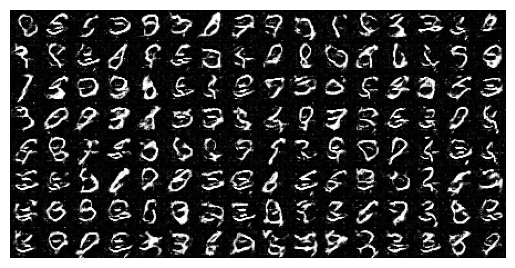

In [13]:
samples = model.generate_img(128, 3)
plt.imshow(
    torch.permute(make_grid(samples, nrow=16, padding=0), (1,2,0)),
    cmap="gray"
)
plt.axis("off")
plt.show()